In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
LEARNING_RATE = 3e-3
EPOCHS = 5
BATCH_SIZE = 32
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NOISE_FACTOR = 10

In [3]:
train_data_df = pd.read_csv("/content/train_data.csv")
test_data_df = pd.read_csv("/content/test_data.csv")

In [4]:
train_data_df.drop(['Unnamed: 0', 'Y'], axis=1, inplace=True)
test_data_df.drop(['Unnamed: 0', 'Y'], axis=1, inplace=True)

In [5]:
train_data_tensor = torch.tensor(train_data_df.to_numpy(), dtype=float)
test_data_tensor = torch.tensor(test_data_df.to_numpy(), dtype=float)

In [6]:
train_data_tensor.shape, test_data_tensor.shape

(torch.Size([60000, 784]), torch.Size([10000, 784]))

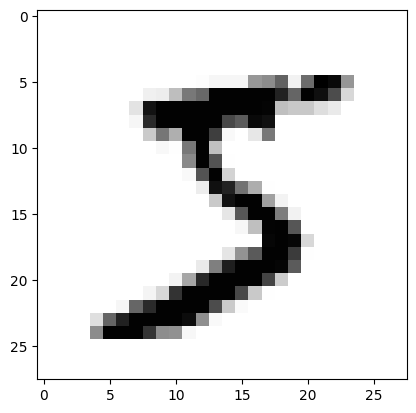

In [7]:
plt.imshow(train_data_tensor[0].view((28, 28)), cmap='Greys');

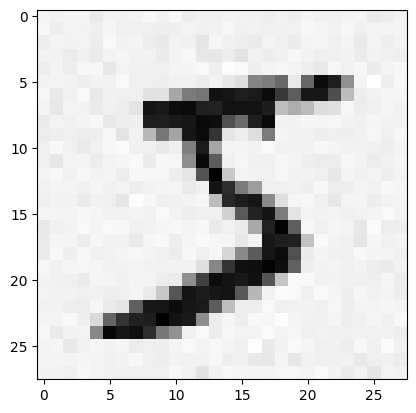

In [8]:
plt.imshow((train_data_tensor[0] + (NOISE_FACTOR * torch.randn_like(train_data_tensor[0]))).view((28, 28)), cmap='Greys')

In [45]:
class AutoEncoder(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        # encoder
        self.e1 = nn.Linear(in_dim, 256)
        self.norme1 = nn.BatchNorm1d(256)
        self.e2 = nn.Linear(256, 64)
        self.norme2 = nn.BatchNorm1d(64)
        self.e3 = nn.Linear(64, 8)
        self.norme3 = nn.BatchNorm1d(8)
        self.relu = nn.ReLU()

        # decoder
        self.d1 = nn.Linear(8, 64)
        self.normd1 = nn.BatchNorm1d(64)
        self.d2 = nn.Linear(64, 256)
        self.normd2 = nn.BatchNorm1d(256)
        self.d3 = nn.Linear(256, in_dim)
        self.normd3 = nn.BatchNorm1d(in_dim)

    def forward(self, x):
        x = x.view((BATCH_SIZE, -1))
        x = self.norme1(self.e1(x))
        x = self.relu(x)
        x = self.norme2(self.e2(x))
        x = self.relu(x)
        x = self.norme3(self.e3(x))
        x = self.relu(x)

        x = self.normd1(self.d1(x))
        x = self.relu(x)
        x = self.normd2(self.d2(x))
        x = self.relu(x)
        x = self.normd3(self.d3(x))
        x = self.relu(x)

        return x

In [76]:
class ConvolutionalAutoEncoder(nn.Module):
    def __init__(self, in_dim=None):
      super().__init__()

      self.enc_block_1 = nn.Sequential(
          nn.Conv2d(1, 16, 3, padding=1),
          nn.BatchNorm2d(16),
          nn.ReLU(),
          nn.MaxPool2d(2, 2),
      )
      self.enc_block_2 = nn.Sequential(
          nn.Conv2d(16, 4, 3, padding=1),
          nn.BatchNorm2d(4),
          nn.ReLU(),
          nn.MaxPool2d(2, 2),
      )
      self.dec_block_1 = nn.Sequential(
          nn.ConvTranspose2d(4, 16, 2, stride=2),
          nn.BatchNorm2d(16),
          nn.ReLU()
      )
      self.dec_block_2 = nn.Sequential(
          nn.ConvTranspose2d(16, 1, 2, stride=2),
          nn.ReLU()
      )


    def forward(self, x):
      x = self.enc_block_1(x)
      x = self.enc_block_2(x)

      x = self.dec_block_1(x)
      x = self.dec_block_2(x)

      return x

In [33]:
class MnistDataset(Dataset):
    def __init__(self, data):
        self.x = data + (NOISE_FACTOR * torch.randn_like(data))
        self.y = data

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [34]:
train_data = DataLoader(MnistDataset(train_data_tensor), batch_size=BATCH_SIZE, shuffle=True)
test_data  = DataLoader(MnistDataset(test_data_tensor),  batch_size=BATCH_SIZE, shuffle=True)

In [47]:
def train_epoch(model, optim, train_data):
    lossi = []
    for x,y in train_data:
      if x.shape[0] != BATCH_SIZE:
        continue
      x = x.view((BATCH_SIZE, 1, 28, 28))
      x, y = x.float().to(DEVICE), y.to(DEVICE)

      output = model(x).view(BATCH_SIZE, -1)
      loss = ((output - y) ** 2).mean()

      optim.zero_grad()
      loss.backward()
      optim.step()

      lossi.append(loss.item())

    return torch.tensor(lossi).mean()


@torch.no_grad()
def test_epoch(model, test_data):
    lossi = []
    for x,y in test_data:
      if x.shape[0] != BATCH_SIZE:
        continue
      x = x.view((BATCH_SIZE, 1, 28, 28))
      x, y = x.float().to(DEVICE), y.to(DEVICE)
      output = model(x).view(BATCH_SIZE, 1, -1)
      loss = ((output - y) ** 2).mean()
      lossi.append(loss.item())

    return torch.tensor(lossi).mean()

In [48]:
model = AutoEncoder(784).to(DEVICE)
optim = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

In [49]:
losses = []
for epoch in range(EPOCHS):
    train_loss = train_epoch(model, optim, train_data)
    test_loss = test_epoch(model, test_data)
    losses.append([train_loss.item(), test_loss.item()])

    print(f"EPOCH: {epoch} | TRAIN_LOSS: {train_loss.item()} | TEST_LOSS: {test_loss.item()}")

EPOCH: 0 | TRAIN_LOSS: 6856.3173828125 | TEST_LOSS: 7046.2001953125
EPOCH: 1 | TRAIN_LOSS: 6210.724609375 | TEST_LOSS: 6786.56494140625
EPOCH: 2 | TRAIN_LOSS: 5661.7236328125 | TEST_LOSS: 6582.89111328125
EPOCH: 3 | TRAIN_LOSS: 5184.7421875 | TEST_LOSS: 6425.04052734375
EPOCH: 4 | TRAIN_LOSS: 4767.5419921875 | TEST_LOSS: 6298.83837890625


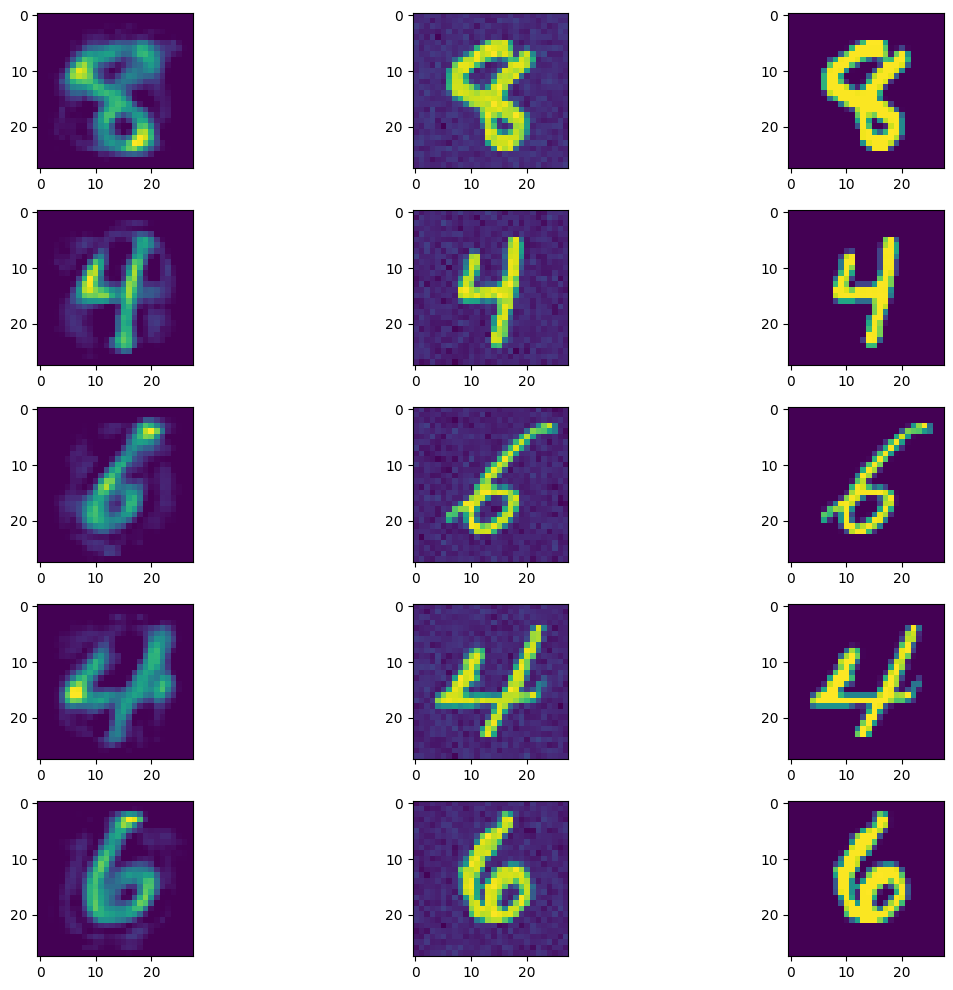

In [50]:
with torch.no_grad():
  plt.figure(figsize=(14, 10))
  c = 15
  plots = 1
  for i, (x,y) in enumerate(test_data):
      plt.subplot(c // 3, 3, plots)
      plt.imshow(model(x.float().view((32, 1, 28, 28)).to(DEVICE))[0].view((28, 28)).cpu().detach().numpy())
      plt.subplot(c // 3, 3, plots + 1)
      plt.imshow(x[0].view((28, 28)).detach().numpy())
      plt.subplot(c // 3, 3, plots + 2)
      plt.imshow(y[0].view((28, 28)).detach().numpy())
      plt.tight_layout()
      plots += 3
      if plots >= c:
          break

In [77]:
model = ConvolutionalAutoEncoder(784).to(DEVICE)
optim = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

In [78]:
losses = []
for epoch in range(EPOCHS):
    train_loss = train_epoch(model, optim, train_data)
    test_loss = test_epoch(model, test_data)
    losses.append([train_loss.item(), test_loss.item()])

    print(f"EPOCH: {epoch} | TRAIN_LOSS: {train_loss.item()} | TEST_LOSS: {test_loss.item()}")

EPOCH: 0 | TRAIN_LOSS: 2033.1451416015625 | TEST_LOSS: 7295.56787109375
EPOCH: 1 | TRAIN_LOSS: 984.3311767578125 | TEST_LOSS: 7623.79638671875
EPOCH: 2 | TRAIN_LOSS: 900.8829956054688 | TEST_LOSS: 7457.77587890625
EPOCH: 3 | TRAIN_LOSS: 860.1625366210938 | TEST_LOSS: 7705.4326171875
EPOCH: 4 | TRAIN_LOSS: 837.4131469726562 | TEST_LOSS: 7714.0849609375


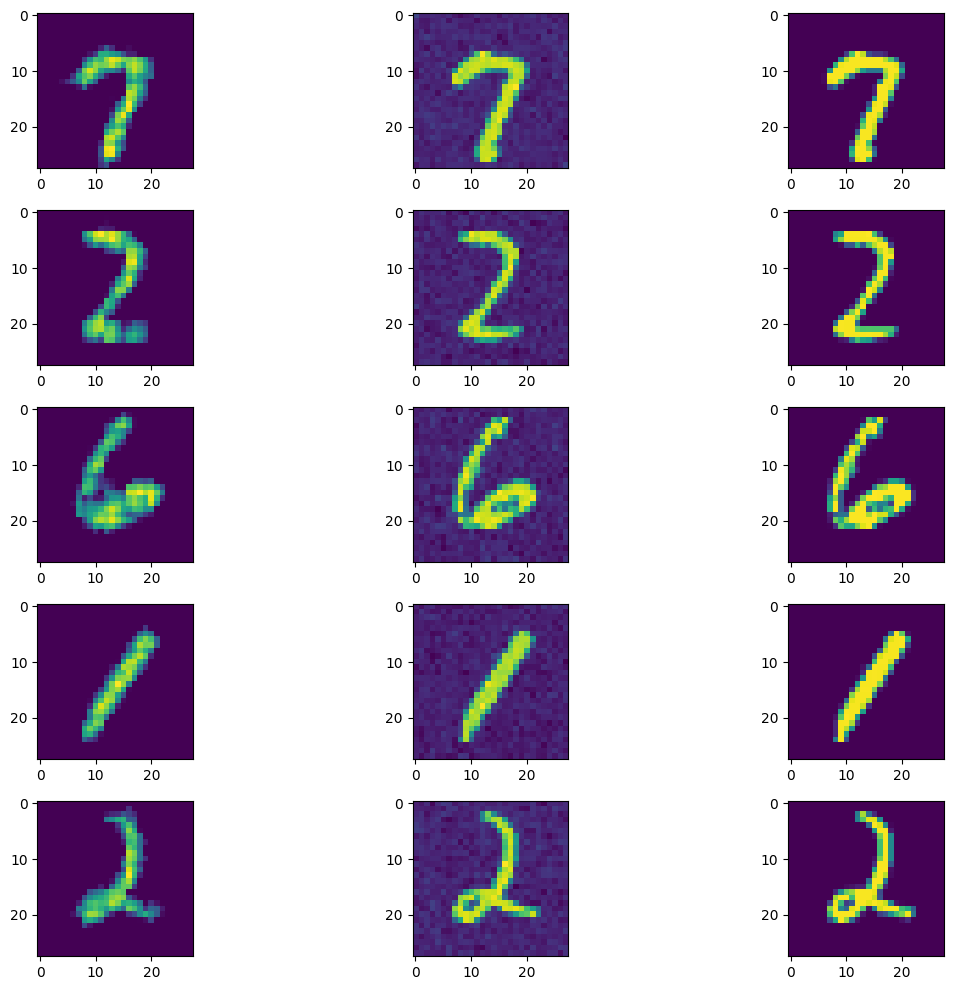

In [79]:
with torch.no_grad():
  plt.figure(figsize=(14, 10))
  c = 15
  plots = 1
  for i, (x,y) in enumerate(test_data):
      plt.subplot(c // 3, 3, plots)
      plt.imshow(model(x.float().view((32, 1, 28, 28)).to(DEVICE))[0].view((28, 28)).cpu().detach().numpy())
      plt.subplot(c // 3, 3, plots + 1)
      plt.imshow(x[0].view((28, 28)).detach().numpy())
      plt.subplot(c // 3, 3, plots + 2)
      plt.imshow(y[0].view((28, 28)).detach().numpy())
      plt.tight_layout()
      plots += 3
      if plots >= c:
          break